In [449]:
## spatial weights with pysal
import pysal as ps
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.api as st
import patsy
import numpy as np
import glob
import os
drop=os.getenv('DROPBOX_LOC')

from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas as gpd
from pyproj import Proj

import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm
import seaborn as sns
#sns.set(style="darkgrid")
plt.style.use('fivethirtyeight')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I grabbed a bunch of viewports' worth of redfin listings and saved them. We load all of them, and kick out dupes.

In [450]:
files=glob.glob(os.path.join(drop,'Documents/Data/Housing/redfin','redfin_2017-06*'))

In [451]:
## Load and drop dupes
keeps=[]
for f in files:
    temp=pd.read_csv(f,parse_dates=['SOLD DATE'])
    keeps.append(temp)
redfin=pd.concat(keeps)
redfin=redfin.drop_duplicates('MLS#')

### Basic processing 

In [452]:
redfin=redfin.rename(columns=lambda x: x.replace(' ','_'))
print redfin.shape
redfin=redfin[redfin.SOLD_DATE.notnull()]
print redfin.shape
redfin['year']=redfin.SOLD_DATE.map(lambda x: x.year)
redfin['month']=redfin.SOLD_DATE.map(lambda x: x.month)
redfin['quarter']=redfin.SOLD_DATE.map(lambda x: x.quarter).astype(str)
redfin['bldg_age_at_sale']=redfin.year-redfin.YEAR_BUILT
redfin['sqft_100']=redfin.SQUARE_FEET/100
redfin['sqft_100_2']=redfin['sqft_100']*redfin['sqft_100']
redfin.LOCATION=redfin.LOCATION.replace({'Montclaire':'Montclair','Montclair Distri':'Montclair',
                                         'Crocker Hghlands':'Crocker Highlands','Glenview (Uppr)':'Upper Glenview',
                                        'Grand Lake/ Rose':'Grand Lake','TemescalRRidge':'Temescal Ridge',
                                        'Oakmore Upper':'Upper Oakmore','Fruitvale Area':'Fruitvale',
                                         'Fruitvale District':'Fruitvale'}).str.title()




redfin[redfin.LONGITUDE.notnull()]
redfin.LOCATION=redfin.LOCATION.str.replace('Dist.$','District').str.replace(' |\-','_').str.replace('\.|/|\-','')

(2327, 27)
(2325, 27)


In [453]:
redfin['LOCATION_recode']=redfin.LOCATION.str.extract('(Glenview|Piedmont|Oakmore)').fillna('Other')


C:\Users\akselo\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [454]:
## Turn to geodataframe

redfin['geometry'] = redfin.apply(lambda x: Point(x.LONGITUDE,x.LATITUDE),axis=1)
redfin = gpd.GeoDataFrame(redfin).set_geometry(col='geometry',crs=from_epsg(4326))


In [455]:
## define variable groups

coords = ['LONGITUDE','LATITUDE']
xvars=['sqft_100','bldg_age_at_sale','year','BATHS','BEDS','LOCATION_recode']
yvar=['PRICE']

In [456]:
subset = redfin.ix[:,yvar+xvars+coords].dropna().\
drop_duplicates(coords).reset_index()
print subset.shape
subset.head()


(2261, 10)


,index,PRICE,sqft_100,bldg_age_at_sale,year,BATHS,BEDS,LOCATION_recode,LONGITUDE,LATITUDE
0,0,2100000,67.83,25.0,2014,4.0,5.0,Piedmont,-122.215851,37.822084
1,1,3500000,63.60,44.0,2015,4.5,5.0,Piedmont,-122.213517,37.819352
2,2,3600000,56.41,78.0,2014,5.5,4.0,Oakmore,-122.209086,37.815662
3,4,2725000,53.57,68.0,2016,5.5,5.0,Piedmont,-122.216005,37.813570
4,5,3700998,52.14,85.0,2015,4.5,5.0,Piedmont,-122.213684,37.817055


In [457]:
w = ps.weights.KNN(subset.loc[:,coords\
                              ].values, k=3)
w.transform = 'R'

w.s2array.shape

(2261L, 1L)

## Check glenview prices over time

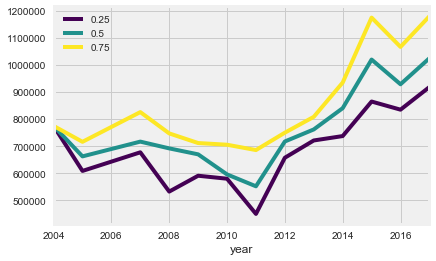

In [458]:
glenview = redfin[redfin.LOCATION=='Glenview']
glenview.groupby(['year']).PRICE.quantile([.25,.5,.75]).unstack(1).plot(cmap='viridis')

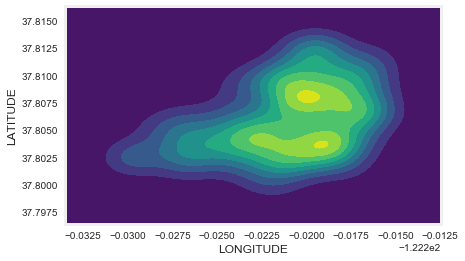

In [459]:
ax = sns.kdeplot(glenview.LONGITUDE,glenview.LATITUDE, shade=True, cmap='viridis');

## Compare regressions run with categorical contrasts vs dummies

I want to see how different the coefficients and model fit might be.

In [460]:
## get dummies for string vars--a bit silly since it is really just the LOCATION variable.

vartypes=subset[xvars].dtypes=='object'
vartypes=vartypes[vartypes==True].index
vartypes

Index([u'LOCATION_recode'], dtype='object')

In [461]:
dummies = pd.get_dummies(subset[vartypes])
print dummies.shape
dummies.head()

(2261, 4)


,LOCATION_recode_Glenview,LOCATION_recode_Oakmore,LOCATION_recode_Other,LOCATION_recode_Piedmont
0,0,0,0,1
1,0,0,0,1
2,0,1,0,0
3,0,0,0,1
4,0,0,0,1


In [462]:
subset=subset.merge(dummies,left_index=True,right_index=True)
subset.head()

,index,PRICE,sqft_100,bldg_age_at_sale,year,BATHS,BEDS,LOCATION_recode,LONGITUDE,LATITUDE,LOCATION_recode_Glenview,LOCATION_recode_Oakmore,LOCATION_recode_Other,LOCATION_recode_Piedmont
0,0,2100000,67.83,25.0,2014,4.0,5.0,Piedmont,-122.215851,37.822084,0,0,0,1
1,1,3500000,63.60,44.0,2015,4.5,5.0,Piedmont,-122.213517,37.819352,0,0,0,1
2,2,3600000,56.41,78.0,2014,5.5,4.0,Oakmore,-122.209086,37.815662,0,1,0,0
3,4,2725000,53.57,68.0,2016,5.5,5.0,Piedmont,-122.216005,37.813570,0,0,0,1
4,5,3700998,52.14,85.0,2015,4.5,5.0,Piedmont,-122.213684,37.817055,0,0,0,1


In [463]:
## Get a list of all enumerated dummy var names, with LOCATION prepended
fulldummylist =[] 
for v in vartypes:
    for c in subset.columns:
        #print c
        if v in c and v!=c:
            
            fulldummylist.append(c)

## remove glenview so dummies are not perfectly collinear
fulldummylist.remove('LOCATION_recode_Glenview')

In [464]:
xvars

['sqft_100', 'bldg_age_at_sale', 'year', 'BATHS', 'BEDS', 'LOCATION_recode']

In [465]:
xvars_num=list(xvars)
for rem in vartypes:
    xvars_num.remove(rem)


In [466]:
## Version treating neighborhoods as contrasts relative to Glenview as base category

sm_ols_contrast_a = sm.ols("np.log(PRICE) ~%s+ C(LOCATION_recode, Treatment(reference='Glenview'))"%'+'.join(xvars_num), 
                  data=subset).fit()
sm_ols_contrast_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(PRICE)   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     299.0
Date:                Fri, 16 Jun 2017   Prob (F-statistic):               0.00
Time:                        19:49:09   Log-Likelihood:                -551.28
No. Observations:                2261   AIC:                             1121.
Df Residuals:                    2252   BIC:                             1172.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -109.5154      6.520    -16.798      0.000    -122.300     -96.730
C(LOCATION_recode, Treatment(reference='Glenview'))[T.Oakmore]      0.0597      0.039      1.517      0.129      -0.017       0.137
C(LOCATION_recode, Treatment(reference='Glenview'))[T.Other]        0.0108      0.026      0.416      0.677      -0.040       0.062
C(LOCATION_recode, Treatment(reference='Glenview'))[T.Piedmont]     0.3554      0.029     12.166      0.000       0.298       0.413
sqft_100                                                            0.0012      0.000      3.647      0.000       0.001       0.002
bldg_age_at_sale                                                    0.0006      0.000      2.195      0.028     6.3e-05       0.001
year                                                                0.0609      0.003     18.783      0.000       0.055       0.067
BATHS                                                               0.1947      0.010     20.036      0.000       0.176       0.214
BEDS                                                                0.0309      0.009      3.304      0.001       0.013       0.049
==============================================================================
Omnibus:                      177.734   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.338
Skew:                          -0.618   Prob(JB):                     1.46e-58
Kurtosis:                       4.141   Cond. No.                     2.02e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [467]:
import re


## Lagged models

Check how much spatial autocorrelation is present in the data. That is, how much is location likely to have a bearing on the observed valuation? If location contains considerable information on the sales price, errors are not independently distributed, violating terms of the OLS estiator. 

One way ot check is $Moran's~I$, which compares values to nearby (lagged) values: how correllated are values with neighbors?

In [468]:
#coeffs={}
moran={}

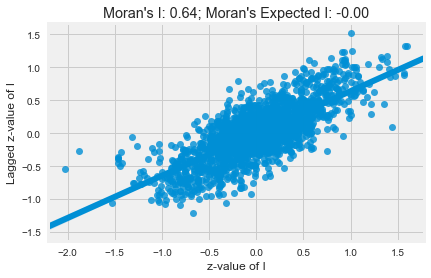

In [469]:
## the slope of the regression line here is equivalent to the Moran's I statistic. There appears to be a pattern:
## high prices (i.e. high z) tend to correlate with *lagged* high prices--and lagged high prices mean neighbors per the
## weights matrix.

morandict = {'I':'Morans I statistic',
'vI':'Morans I variance',
'eI':'Morans I expectation',
'zI':'Morans I standardized value',
'p_norm':'P-value'}

def moranplotter():
    mor = ps.Moran(y=np.log(subset.PRICE).values, w=w, transformation = 'r',)
    zx = mor.z
    zy = ps.lag_spatial(w, mor.z)
    fit = ps.spreg.OLS(zy[:, None], zx[:,None])
    ax = sns.regplot(x=zx, y=zy)
    ax.set(xlabel='z-value of I', ylabel='Lagged z-value of I')
    title('Moran\'s I: {moran_i:03.2f}; Moran\'s Expected I: {moran_ei:03.2f}'.format(moran_i=mor.I,moran_ei=mor.EI))
moranplotter()

## Run models and store output in dict for comparison

In [470]:
coeffs={}


y,X = patsy.dmatrices("np.log(PRICE) ~%s+ C(LOCATION_recode, Treatment(reference='Glenview'))"%'+'.join(xvars_num), 
                  data=subset,return_type='dataframe')

## design matrix version
sm_ols_contrast_b = sm.OLS(y, X).fit(cov_type='HC3')

## tokenize location to get just the actual name--extract from unwieldy string
## both lookahead and lookbehind--get content wrapped between T. and ]

ptrn = '(?<=T\.)(.*?)(?=\])' 
m=re.compile(ptrn)
sm_ols_contrast_b_params={}
sm_ols_contrast_b_tvalues={}
for k,v in sm_ols_contrast_b.params.to_dict().iteritems():
    if 'Treatment' in k and 'LOCATION' in k:
        sm_ols_contrast_b_params[m.search(k).group()]=v
    else:
        sm_ols_contrast_b_params[k]=v
for k,v in sm_ols_contrast_b.tvalues.to_dict().iteritems():
    if 'Treatment' in k and 'LOCATION' in k:
        sm_ols_contrast_b_tvalues[m.search(k).group()]=v
    else:
        sm_ols_contrast_b_tvalues[k]=v
        

coeffs[('0: sm_ols_contrast','params')]=pd.Series(sm_ols_contrast_b_params).rename(index={'Intercept':'CONSTANT'})
coeffs[('0: sm_ols_contrast','tstats')]=pd.Series(sm_ols_contrast_b_tvalues).rename(index={'Intercept':'CONSTANT'})

## dummy version instead--notice the R squared in the .29 territory as opposed to .66 for the contrast version

sm_ols_dummy = sm.ols("np.log(PRICE) ~%s"%'+'.join(xvars_num+fulldummylist), 
                  data=subset).fit(cov_type='HC3')

ptrn2 = '(?<=LOCATION\_recode\_)(.*)' 
m=re.compile(ptrn2)
sm_ols_dummy_params={}
sm_ols_dummy_tvalues={}

for k,v in sm_ols_dummy.params.to_dict().iteritems():
    if k.startswith('LOCATION'):
        sm_ols_dummy_params[m.search(k).group()]=v
    else:
        sm_ols_dummy_params[k]=v
for k,v in sm_ols_dummy.tvalues.to_dict().iteritems():
    if k.startswith('LOCATION'):
        sm_ols_dummy_tvalues[m.search(k).group()]=v
    else:
        sm_ols_dummy_tvalues[k]=v

coeffs[('1: sm_ols_dummy','params')]=pd.Series(sm_ols_dummy_params).rename(index={'Intercept':'CONSTANT'})
coeffs[('1: sm_ols_dummy','tstats')]=pd.Series(sm_ols_dummy_tvalues).rename(index={'Intercept':'CONSTANT'})

In [471]:
## pysal plain
ps_ols = ps.spreg.OLS(np.log(subset.PRICE).values[:, None], 
          subset[xvars_num+fulldummylist].values, \
          w=w, 
                  spat_diag=True, \
          name_x=subset[xvars_num+fulldummylist].columns.tolist(), name_y='ln(price)') 
ps_ols_x=[x.replace('LOCATION_recode_','') if x.startswith('LOCATION') else x for x in ps_ols.name_x]

coeffs[('2: ps_ols','params')]=pd.Series(ps_ols.betas[:,0],index=ps_ols_x)
coeffs[('2: ps_ols','tstats')]=pd.Series(pd.DataFrame(ps_ols.t_stat)[0].values,index=ps_ols_x)


In [474]:
## endogenous lag--pysal uses moments to estimate since it violates OLS rules

ps_lag = ps.spreg.GM_Lag(y=np.log(subset.PRICE).values[:, None], 
                         x=subset[xvars_num+fulldummylist].values, \
                  w=w, spat_diag=True, \
                  name_x=subset[xvars_num+fulldummylist].columns.tolist(), name_y='ln(price)') 

ps_lag_x=[x.replace('LOCATION_recode_','') if x.startswith('LOCATION') else x for x in ps_lag.name_x]+['_lag_y']

coeffs[('3: ps_gm_endog','params')]=pd.Series(ps_lag.betas[:,0],index=ps_lag_x)
coeffs[('3: ps_gm_endog','tstats')]=pd.Series(pd.DataFrame(ps_lag.z_stat)[0].values,index=ps_lag_x)
print ps_lag.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        2261
Mean dependent var  :     13.8762                Number of Variables   :          10
S.D. dependent var  :      0.4435                Degrees of Freedom    :        2251
Pseudo R-squared    :      0.6976
Spatial Pseudo R-squared:  0.5445

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -109.3434312       5.1738703     -21.1337788       0.0000000
            sqft_100       0.0009466       0.0002515       3.7632729       0.0001677
    bldg_age_at_sale       0.0007054       0.0002134       

### Compare parameters for the approaches

All the diagnostics for spatial dependence for RESIDUAL spatial autocorrelation, after controlling for covariates, are significant.

In [477]:
combomodels = pd.concat(coeffs).reset_index(name='value').\
rename(columns={'level_0':'model', 'level_1':'variable','level_2':'parameter'}).\
set_index(['model','variable','parameter']).unstack(level=['variable','model']).value.sort_index(axis=1)
combomodels.params.sort_values('3: ps_gm_endog')

model,0: sm_ols_contrast,1: sm_ols_dummy,2: ps_ols,3: ps_gm_endog
parameter,,,,
CONSTANT,-109.515364,-109.515364,-109.515364,-109.343431
Other,0.010794,0.010794,0.010794,-0.098807
Oakmore,0.059682,0.059682,0.059682,-0.061897
bldg_age_at_sale,0.000590,0.000590,0.000590,0.000705
sqft_100,0.001154,0.001154,0.001154,0.000947
BEDS,0.030937,0.030937,0.030937,0.033291
year,0.060874,0.060874,0.060874,0.058089
Piedmont,0.355385,0.355385,0.355385,0.093978
BATHS,0.194689,0.194689,0.194689,0.152141


First, we note that all the OLS methods, whether contrast or dummy, or statsmodel or pysal, return identical coefficients. That is reassuring.

With respect to the endogenous lag model, it is noteworthy that structural variables (bed, bath, ear of sale, building age) are very similar between it and the OLS coefficients. What changes are the values of the neighborhood dummies. Once taking into account the spatial lag, the neighborhood dummies lose strength (Piedmont), or even turn negative (Oakmore, rest of Oakland). This is probably because the lag is focused much closer on the sales transaction, whereas these dummy neighborhoods can be quite large and heterogeneous. We inadvertently backed [Tobler's first law of geography!](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography).

In [476]:
# ps.lag_spatial(w,y)

# X_v = X.assign(w_pool=ps.lag_spatial(w_pool, yxs['pool'].values))